# Applied Data Science Capstone Project

This case study is the Applied Data Science Capstone Project in the IBM Data Science Professional Program. This study does not only serve as a demonstration of the skills that I have acquired, hopefully it can also demonstrate the power and versatility of common data science methods. The audience of this article are not necessarily just scientist and researchers but the general public and especially those with an interest in the applications of data science.

All the code as well as the used data set can be found on GitHub https://github.com/dcadosch/Coursera_Capstone

## Introduction

At least since we use wheeled motor vehicles for transportation, traffic collisions are an unfortunate but inherent aspect of it. The severity of accidents varies for a number of reasons. Roads may not be designed in a safe way or crucial parts of vehicles may fail while driving due to insufficient maintenance or due to engineering faults of the vehicle manufacturer. The driver may be distracted or violate safety rules and laws by speeding or driving under the influence of alcohol or drugs. There are also environmental factors that may influence the severity of a collision. A law-abiding driver who takes appropriate care of her or his vehicle can only influence a few of these factors that govern the outcome of a collision. However, it is difficult to judge these factors without a thorough analysis of the data of past collision events.

In this case study I am creating a machine learning model that estimates the severity of collision events based on a number of environmental factors. The severity of collisions is divided into multiple classes, which means that we need to employ a classification algorithm. In order to be able to choose an optimal classification algorithm, we will deploy multiple methods and compare their performance by measuring several evaluation metrics.

This case study will focus on traffic accidents in an urban environment in the United States of America. Hence, it might not be applicable to situations that differ considerably from such a scenario. The general approach of this study might nonetheless serve as a guide to create a similar model with data from another source.

## Data Understanding

The data to train and evaluate the model was obtained from the 'City of Seattle Open Data Portal' (https://data.seattle.gov/Land-Base/Collisions/9kas-rb8d). The data set contains all reported vehicle collisions in Seattle from January 1, 2004 to October 9, 2020. The table contains 40 columns and 221,525 incidents. Not all of the columns contain relevant or usable information for the task at hand. Furthermore, not all incidents have a complete set of information. These incidents may need to be removed from the data set.

The most relevant feature is the severity of an accident. In the original data set the severity is divided into four classes: property damage, injury, serious injury, and fatality. The model will be trained to predict the severity class based on other available information. Independent features that a driver may observe before a collision occurs are for example the road and light conditions, the weather and the kind of road (s)he is in. All these features are divided into about ten classes each. Other features such as the month of the year or the time of the day may be extracted from the timestamp in the data set. Collision data that can only be obtained after the collision occurred such as the type of collision or whether any person involved was driving under influence will not be used in the training of the classification algorithms.

In [6]:
# load necessary data handling libraries
import numpy as np
import pandas as pd

In [7]:
# this line completes a task that was part of an assignment
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


In [8]:
# read csv file and store it in a data frame
df = pd.read_csv('Collisions.csv')

C:\Users\admin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (35) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
# get an overview of the data structure and content
df.head()

X              Y  OBJECTID  INCKEY  COLDETKEY REPORTNO  \
0  1.268354e+06  265256.609668         1    1003       1003  3503158   
1  1.259316e+06  202173.388163         2   56200      56200  1795087   
2  1.264342e+06  259613.000382         3  327037     328537  E979380   
3  1.279221e+06  222017.872023         4  327278     328778  E996362   
4  1.262205e+06  242179.124204         5    1248       1248  3645424   

      STATUS      ADDRTYPE   INTKEY  \
0    Matched         Block      NaN   
1    Matched         Block      NaN   
2    Matched  Intersection  37122.0   
3  Unmatched  Intersection  30602.0   
4  Unmatched         Block      NaN   

                                           LOCATION  ... ROADCOND  \
0    AURORA AVE N BETWEEN N 117TH PL AND N 125TH ST  ...      Dry   
1  35TH AVE SW BETWEEN SW MORGAN ST AND SW HOLLY ST  ...      Dry   
2                        3RD AVE NW AND NW 100TH ST  ...      Wet   
3                M L KING JR WAY S AND S JACKSON ST  ...      NaN   
4       W EWING ST BETWEEN 6TH AVE W AND W EWING PL  ...      NaN   

                 LIGHTCOND PEDROWNOTGRNT SDOTCOLNUM SPEEDING  ST_COLCODE  \
0                 Daylight             Y        NaN      NaN          45   
1  Dark - Street Lights On           NaN  6015003.0      NaN           0   
2                 Daylight           NaN        NaN      NaN          10   
3                      NaN           NaN        NaN      NaN               
4                      NaN           NaN        NaN      NaN               

                               ST_COLDESC  SEGLANEKEY  CROSSWALKKEY  \
0                  Vehicle - Pedalcyclist       15057             0   
1  Vehicle going straight hits pedestrian           0             0   
2                       Entering at angle           0             0   
3                                     NaN           0             0   
4                                     NaN           0             0   

   HITPARKEDCAR  
0             N  
1             N  
2             N  
3             N  
4             N  

[5 rows x 40 columns]

In [10]:
# get the size of the data frame
df.shape

(221525, 40)

In [11]:
# The X and Y coordinates in the original csv file to not correspond to latitude and longitude measures. Longitude and
# latitude coordinates are available in a geojson file that can be downloaded from the same site as the data set in the csv
# format. The json library will be needed to load the geojson file.

import json

with open('Collisions.geojson') as f:
    data = json.load(f)

In [12]:
# A secondary data frame with a key column (INCKEY) will be created to store the extracted coordinates. The private key will
# be used to merge the two data frames. In order to predefine the data frame to have the appropriate size it will copy the
# 'INCKEY', 'X', 'Y' column from the original data frame and subsequently be overwritten with the extracted data from the
# geojson file. This is probably faster than appending rows for every extracted incident.

df_coordinates = df.loc[:,['INCKEY']]

df_coordinates['LATITUDE'] = df['X']
df_coordinates['LONGITUDE'] = df['Y']

# overwrite data frame to make sure that no original information will remain
df_coordinates.loc[:,:] = None

In [13]:
# Create a loop to cycle through all the entries in the geojson data frame, extract the INCKEY and the coordinates, and store
# them in the secondary data frame.

loop_count = 0

for feature in data['features']:
    # Some entries do not have coordinates. Check whether they exist, otherwise an error will occur.
    if feature['geometry'] != None:
        df_coordinates.loc[loop_count, 'LATITUDE'] = feature['geometry']['coordinates'][1]
        df_coordinates.loc[loop_count, 'LONGITUDE'] = feature['geometry']['coordinates'][0]
    df_coordinates.loc[loop_count, 'INCKEY'] = feature['properties']['INCKEY']
    loop_count += 1

In [14]:
# Merge / inner join the two data frames based on the INCKEY column that is present in both data frames.
df = pd.merge(df, df_coordinates, how = 'inner', on = 'INCKEY')

In [15]:
# install the folium package for map visualizations
!conda install -c conda-forge folium=0.11.0 --yes

Solving environment: ...working... done

# All requested packages already installed.



To get an initial overview of the nature of the data that will be used it might be helpful to have a geographic visualization. The following map shows all recorded collision incidents in 2020 up to October 9 for which the coordinates were available. From this map we can see the boundaries of the geographic area from which the data stems. We can further see that the incidents are not homogeneously distributed. There are certain areas where incidents are clustered. That clustering might be due to higher amounts of traffic, particularly dangerous roads or simply due to stochastic effects. Since we do not know the reason for the clustering, we will not use the location data any further in our study.

In [16]:
# Load the folium library and use the newly obtained latitude and longitude coordinates to mark every incident. Because of
# the large number of incidents we will restrict the visualization to incidents that happened in 2020 up to October 9.

import folium

seattle_map = folium.Map(location = [47.607568212024205,-122.32992013710938], zoom_start = 11)

df_withLocation = df[df['LATITUDE'].notnull()]

df_limit2020 = df_withLocation[df_withLocation['INCDATE'] > '2020']

accidents = folium.map.FeatureGroup()

for lat, lng, in zip(df_limit2020['LATITUDE'], df_limit2020['LONGITUDE']):
    #print(lat, lng)
    accidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=1, # define how big you want the circle markers to be
            color='red',
            fill = True,
            fill_color = 'red'
        )
    )
    
seattle_map.add_child(accidents)

In [17]:
# we need to have the selenium package and an equally up-to-date installation of Firefox to export the map visualization
!conda install -c conda-forge selenium --yes

Solving environment: ...working... done

# All requested packages already installed.



In [18]:
# export the generated map to a png file
import io
from PIL import Image

img_data = seattle_map._to_png(5)
img = Image.open(io.BytesIO(img_data))
img.save('seattle_map.png')

In [19]:
df.loc[:, 'PEDES'] = 0
df.loc[df['PEDCOUNT'] > 0, 'PEDES'] = 1

df.loc[:, 'CYCL'] = 0
df.loc[df['PEDCYLCOUNT'] > 0, 'CYCL'] = 1

df.loc[:, 'VEHIC'] = 0
df.loc[df['VEHCOUNT'] > 0, 'VEHIC'] = 1


In [18]:
df = df.drop(['X',
              'Y',
              'OBJECTID',
              'INCKEY',
              'INTKEY',
              'SEVERITYDESC',
              'COLLISIONTYPE',
              'PERSONCOUNT',
              'PEDCOUNT',
              'PEDCYLCOUNT',
              'VEHCOUNT',
              'INJURIES',
              'SERIOUSINJURIES',
              'FATALITIES',
              'COLDETKEY', 
              'REPORTNO', 
              'STATUS',
              'LOCATION', 
              'EXCEPTRSNCODE', 
              'EXCEPTRSNDESC',
              'SDOT_COLCODE',
              'SDOT_COLDESC',
              'SDOTCOLNUM',
              'SEGLANEKEY',
              'CROSSWALKKEY',
              'ST_COLCODE',
              'ST_COLDESC',
              'HITPARKEDCAR'], axis = 1)
#df.loc['OBJECTID'].head()
#df.loc[0:5,'OBJECTID']
df.shape

(221525, 17)

In [19]:
df.loc[:,'SEVERITYCODE'].unique()

array(['2', '1', '0', '3', '2b', nan], dtype=object)

In [20]:
unknowns = df[(df['SEVERITYCODE'].isnull()) | (df['SEVERITYCODE'] == '0')].shape[0]
print(unknowns, 'incidents have been excluded due to the severity being unknown.')

df = df[(df['SEVERITYCODE'].notnull()) & (df['SEVERITYCODE'] != '0')].copy()

df.loc[:,'SEVERITYCODE'].replace(['1', '2', '2b', '3'], [0, 1, 2, 3], inplace = True)

21616 incidents have been excluded due to the severity being unknown.


In [21]:
df['SEVERITYCODE'].value_counts()

0    137671
1     58783
2      3105
3       350
Name: SEVERITYCODE, dtype: int64

In [28]:
df['SEVERITYCODE'].value_counts() / df.shape[0] * 100

0    68.866834
1    29.404879
2     1.553207
3     0.175080
Name: SEVERITYCODE, dtype: float64

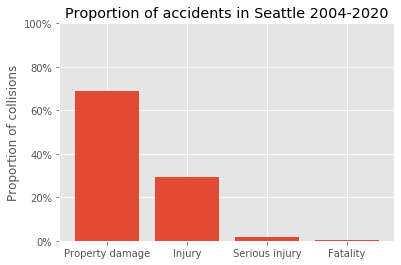

In [27]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import PercentFormatter

mpl.style.use('ggplot')

x = df['SEVERITYCODE'].unique().tolist()
x.sort()

plt.bar(x, df['SEVERITYCODE'].value_counts() / df.shape[0] * 100)

severity_descs = ['Property damage', 'Injury', 'Serious injury', 'Fatality']

plt.xticks(x, labels = severity_descs)
plt.title('Proportion of accidents in Seattle 2004-2020')
plt.ylabel('Proportion of collisions')

axes = plt.gca()
axes.set_ylim([0, 100])
axes.yaxis.set_major_formatter(mtick.PercentFormatter())

In [368]:
df.loc[:,'SIMP_SC'] = df.loc[:,'SEVERITYCODE'].replace([2, 3], 1)

In [369]:
df.loc[:,'SIMP_SC'].unique()

array([1, 0], dtype=int64)

In [24]:
x = df['SIMP_SC'].unique().tolist()
x.sort()

plt.bar(x, df['SIMP_SC'].value_counts())

severity_descs = ['Property damage', 'Injury']

plt.xticks(x, labels = severity_descs)
plt.title('Number of accidents in Seattle 2004-2020')
plt.ylabel('Count')



KeyError: 'SIMP_SC'

In [371]:
df.describe(include = 'all')

X              Y ADDRTYPE   SEVERITYCODE  \
count   1.945020e+05  194502.000000   197978  199909.000000   
unique           NaN            NaN        3            NaN   
top              NaN            NaN    Block            NaN   
freq             NaN            NaN   129760            NaN   
mean    1.271193e+06  229554.561012      NaN       0.330365   
std     7.347494e+03   20544.901402      NaN       0.512635   
min     1.249026e+06  184059.089000      NaN       0.000000   
25%     1.266766e+06  213565.004400      NaN       0.000000   
50%     1.271169e+06  228063.765700      NaN       0.000000   
75%     1.276052e+06  245747.797600      NaN       1.000000   
max     1.293052e+06  271525.414800      NaN       3.000000   

                       INCDATE   INCDTTM  \
count                   199909    199909   
unique                    6097    167019   
top     2006/11/02 00:00:00+00  11-02-06   
freq                       100       100   
mean                       NaN       NaN   
std                        NaN       NaN   
min                        NaN       NaN   
25%                        NaN       NaN   
50%                        NaN       NaN   
75%                        NaN       NaN   
max                        NaN       NaN   

                                   JUNCTIONTYPE INATTENTIONIND UNDERINFL  \
count                                    193528          30188    195230   
unique                                        7              1         4   
top     Mid-Block (not related to intersection)              Y         N   
freq                                      92135          30188    103925   
mean                                        NaN            NaN       NaN   
std                                         NaN            NaN       NaN   
min                                         NaN            NaN       NaN   
25%                                         NaN            NaN       NaN   
50%                                         NaN            NaN       NaN   
75%                                         NaN            NaN       NaN   
max                                         NaN            NaN       NaN   

       WEATHER ROADCOND LIGHTCOND PEDROWNOTGRNT SPEEDING          PEDES  \
count   195019   195100    194930          5194     9928  199909.000000   
unique      12        9         9             1        1            NaN   
top      Clear      Dry  Daylight             Y        Y            NaN   
freq    114737   128588    119489          5194     9928            NaN   
mean       NaN      NaN       NaN           NaN      NaN       0.040378   
std        NaN      NaN       NaN           NaN      NaN       0.196846   
min        NaN      NaN       NaN           NaN      NaN       0.000000   
25%        NaN      NaN       NaN           NaN      NaN       0.000000   
50%        NaN      NaN       NaN           NaN      NaN       0.000000   
75%        NaN      NaN       NaN           NaN      NaN       0.000000   
max        NaN      NaN       NaN           NaN      NaN       1.000000   

                 CYCL          VEHIC        SIMP_SC  
count   199909.000000  199909.000000  199909.000000  
unique            NaN            NaN            NaN  
top               NaN            NaN            NaN  
freq              NaN            NaN            NaN  
mean         0.030059       0.975374       0.311332  
std          0.170749       0.154983       0.463039  
min          0.000000       0.000000       0.000000  
25%          0.000000       1.000000       0.000000  
50%          0.000000       1.000000       0.000000  
75%          0.000000       1.000000       1.000000  
max          1.000000       1.000000       1.000000

In [372]:
df.groupby('VEHIC')['SIMP_SC'].agg(['count', 'mean', 'std', 'sem'])

count      mean       std       sem
VEHIC                                      
0        4923  0.245176  0.430235  0.006132
1      194986  0.313002  0.463716  0.001050

In [373]:
df['DATE_TIME'] = pd.to_datetime(df['INCDTTM'])

In [374]:
df['DATE_TIME'].dt.time.head()

0    17:30:00
1    17:35:00
2    15:32:00
3    00:00:00
5    00:00:00
Name: DATE_TIME, dtype: object

In [375]:
df['DATE_TIME'].dt.time.head() == pd.to_datetime('00:00:00').time()

0    False
1    False
2    False
3     True
5     True
Name: DATE_TIME, dtype: bool

In [376]:
unknowns = df.loc[df['DATE_TIME'].dt.time == pd.to_datetime('00:00:00').time(),:].shape[0]
print(unknowns, 'incidents have been excluded due to the time of the accident being unknown.')

df = df.loc[df['DATE_TIME'].dt.time != pd.to_datetime('00:00:00').time(),:].copy()

#df.loc[:,'SEVERITYCODE'].replace(['1', '2', '2b', '3'], [0, 1, 2, 3], inplace = True)

30759 incidents have been excluded due to the time of the accident being unknown.


In [377]:
df['YEAR'] = df['DATE_TIME'].dt.year
df['MONTH'] = df['DATE_TIME'].dt.month_name()
df['HOUR'] = df['DATE_TIME'].dt.hour
df['DAYOFWEEK'] = df['DATE_TIME'].dt.day_name()


In [378]:
df.groupby('HOUR')['SEVERITYCODE'].agg(['count', 'mean', 'std', 'sem'])

count      mean       std       sem
HOUR                                     
0      3990  0.269925  0.507722  0.008038
1      3550  0.303380  0.539314  0.009052
2      3729  0.289622  0.518749  0.008495
3      1738  0.256617  0.504185  0.012094
4      1276  0.271944  0.509237  0.014256
5      1727  0.329473  0.521568  0.012551
6      3331  0.363254  0.542063  0.009392
7      6748  0.363811  0.525875  0.006402
8      8788  0.337733  0.505304  0.005390
9      8258  0.324534  0.501210  0.005515
10     7669  0.310732  0.496536  0.005670
11     8415  0.318360  0.500785  0.005459
12    10680  0.311798  0.494535  0.004785
13    10487  0.326118  0.500874  0.004891
14    10917  0.345699  0.512516  0.004905
15    11871  0.352371  0.514575  0.004723
16    12474  0.362915  0.522414  0.004677
17    13350  0.381124  0.527244  0.004563
18    10068  0.382598  0.538221  0.005364
19     7465  0.342800  0.511887  0.005925
20     6434  0.313646  0.509060  0.006346
21     5792  0.334599  0.533387  0.007009
22     5628  0.310768  0.506132  0.006747
23     4765  0.280797  0.501947  0.007272

In [379]:
df['INCDTTM'].head(20)

0       3/14/2013 5:30:00 PM
1       1/15/2006 5:35:00 PM
2             09-09-19 15:32
6      7/31/2020 10:29:00 AM
8             04-11-06 16:15
9             04-03-13 13:03
10     3/30/2013 11:12:00 AM
11      3/31/2013 3:44:00 AM
12      6/13/2006 8:45:00 AM
13     12/23/2019 4:36:00 PM
14     4/17/2007 11:19:00 AM
15     9/17/2004 11:34:00 PM
16    12/20/2019 12:02:00 AM
17      3/27/2013 8:45:00 PM
18            05-03-20 12:21
19     12/22/2019 5:10:00 AM
20      8/31/2019 3:54:00 PM
21            04-01-13 12:52
23      3/26/2013 9:27:00 AM
25     12/17/2019 7:47:00 PM
Name: INCDTTM, dtype: object

In [380]:
df.describe

<bound method NDFrame.describe of                   X            Y      ADDRTYPE  SEVERITYCODE  \
0       1268353.834  265256.6097         Block             1   
1       1259315.751  202173.3882         Block             1   
2       1264342.056  259613.0004  Intersection             0   
6       1269242.946  231901.4394  Intersection             0   
8       1275538.274  241908.5121         Block             0   
...             ...          ...           ...           ...   
221519  1263928.767  254313.3034         Block             1   
221520  1262739.523  210740.9372         Block             1   
221521  1273684.666  242477.2372         Block             0   
221522  1284910.583  199313.5747         Block             0   
221523  1267113.104  227934.7977  Intersection             0   

                       INCDATE                 INCDTTM  \
0       2013/03/14 00:00:00+00    3/14/2013 5:30:00 PM   
1       2006/01/15 00:00:00+00    1/15/2006 5:35:00 PM   
2       2019/09/09 00:0

In [381]:
unknowns = df[df.loc[:,'UNDERINFL'].isnull()].shape[0]
print(unknowns, 'incidents have been excluded due to the \'UNDERINFL\' feature being unknown.')

df = df[df.loc[:,'UNDERINFL'].notnull()].copy()

#df.loc[:,['UNDERINFL']] = df.loc[:,['UNDERINFL']].replace(['N','Y'],['0', '1'])

df.loc[:,'UNDERINFL'].replace(['N','Y'],['0', '1'], inplace = True)

#df['UNDERINFL'] = df['UNDERINFL'].replace(['N','Y'],['0', '1'])

##df['UNDERINFL'] = df['UNDERINFL'].astype(str)
#df.loc[:,'UNDERINFL'] = df.loc[:,'UNDERINFL'].astype(int)



0 incidents have been excluded due to the 'UNDERINFL' feature being unknown.


In [382]:
df['UNDERINFL'].unique()

array(['0', '1'], dtype=object)

In [383]:
isinstance(df, pd.DataFrame)

True

In [384]:
df.loc[:, 'UNDERINFL'].unique()

array(['0', '1'], dtype=object)

In [385]:
df.describe(include = 'all')

X              Y ADDRTYPE   SEVERITYCODE  \
count   1.646580e+05  164658.000000   167542  169150.000000   
unique           NaN            NaN        3            NaN   
top              NaN            NaN    Block            NaN   
freq             NaN            NaN   108967            NaN   
first            NaN            NaN      NaN            NaN   
last             NaN            NaN      NaN            NaN   
mean    1.271207e+06  229457.570447      NaN       0.335483   
std     7.349337e+03   20610.049743      NaN       0.514740   
min     1.249026e+06  184059.089000      NaN       0.000000   
25%     1.266783e+06  213326.135700      NaN       0.000000   
50%     1.271181e+06  227975.519600      NaN       0.000000   
75%     1.276067e+06  245742.849700      NaN       1.000000   
max     1.293052e+06  271525.414800      NaN       3.000000   

                       INCDATE                INCDTTM  \
count                   169150                 169150   
unique                    5472                 164062   
top     2005/05/18 00:00:00+00  11/22/2010 7:00:00 PM   
freq                        87                      7   
first                      NaN                    NaN   
last                       NaN                    NaN   
mean                       NaN                    NaN   
std                        NaN                    NaN   
min                        NaN                    NaN   
25%                        NaN                    NaN   
50%                        NaN                    NaN   
75%                        NaN                    NaN   
max                        NaN                    NaN   

                                   JUNCTIONTYPE INATTENTIONIND UNDERINFL  \
count                                    163380          27274    169150   
unique                                        7              1         2   
top     Mid-Block (not related to intersection)              Y         0   
freq                                      78015          27274    160790   
first                                       NaN            NaN       NaN   
last                                        NaN            NaN       NaN   
mean                                        NaN            NaN       NaN   
std                                         NaN            NaN       NaN   
min                                         NaN            NaN       NaN   
25%                                         NaN            NaN       NaN   
50%                                         NaN            NaN       NaN   
75%                                         NaN            NaN       NaN   
max                                         NaN            NaN       NaN   

       WEATHER  ... SPEEDING          PEDES           CYCL          VEHIC  \
count   168943  ...     8416  169150.000000  169150.000000  169150.000000   
unique      12  ...        1            NaN            NaN            NaN   
top      Clear  ...        Y            NaN            NaN            NaN   
freq     99715  ...     8416            NaN            NaN            NaN   
first      NaN  ...      NaN            NaN            NaN            NaN   
last       NaN  ...      NaN            NaN            NaN            NaN   
mean       NaN  ...      NaN       0.042696       0.031966       0.998646   
std        NaN  ...      NaN       0.202171       0.175909       0.036770   
min        NaN  ...      NaN       0.000000       0.000000       0.000000   
25%        NaN  ...      NaN       0.000000       0.000000       1.000000   
50%        NaN  ...      NaN       0.000000       0.000000       1.000000   
75%        NaN  ...      NaN       0.000000       0.000000       1.000000   
max        NaN  ...      NaN       1.000000       1.000000       1.000000   

              SIMP_SC            DATE_TIME           YEAR    MONTH  \
count   169150.000000               169150  169150.000000   169150   
unique            NaN               164062           

In [386]:
df.shape

(169150, 23)

In [387]:
df[['SPEEDING', 'INATTENTIONIND', 'PEDROWNOTGRNT']] = df[['SPEEDING', 'INATTENTIONIND', 'PEDROWNOTGRNT']].fillna(0)
df[['SPEEDING', 'INATTENTIONIND', 'PEDROWNOTGRNT']] = df[['SPEEDING', 'INATTENTIONIND', 'PEDROWNOTGRNT']].replace('Y', 1)
df[['SPEEDING', 'INATTENTIONIND', 'PEDROWNOTGRNT', 'UNDERINFL']] = df[['SPEEDING', 'INATTENTIONIND', 'PEDROWNOTGRNT', 'UNDERINFL']].astype(int)

In [388]:
df[['SPEEDING', 'INATTENTIONIND', 'PEDROWNOTGRNT']].head()

SPEEDING  INATTENTIONIND  PEDROWNOTGRNT
0         0               0              1
1         0               0              0
2         0               0              0
6         0               0              0
8         0               0              0

In [389]:
df.describe(include = 'all')

X              Y ADDRTYPE   SEVERITYCODE  \
count   1.646580e+05  164658.000000   167542  169150.000000   
unique           NaN            NaN        3            NaN   
top              NaN            NaN    Block            NaN   
freq             NaN            NaN   108967            NaN   
first            NaN            NaN      NaN            NaN   
last             NaN            NaN      NaN            NaN   
mean    1.271207e+06  229457.570447      NaN       0.335483   
std     7.349337e+03   20610.049743      NaN       0.514740   
min     1.249026e+06  184059.089000      NaN       0.000000   
25%     1.266783e+06  213326.135700      NaN       0.000000   
50%     1.271181e+06  227975.519600      NaN       0.000000   
75%     1.276067e+06  245742.849700      NaN       1.000000   
max     1.293052e+06  271525.414800      NaN       3.000000   

                       INCDATE                INCDTTM  \
count                   169150                 169150   
unique                    5472                 164062   
top     2005/05/18 00:00:00+00  11/22/2010 7:00:00 PM   
freq                        87                      7   
first                      NaN                    NaN   
last                       NaN                    NaN   
mean                       NaN                    NaN   
std                        NaN                    NaN   
min                        NaN                    NaN   
25%                        NaN                    NaN   
50%                        NaN                    NaN   
75%                        NaN                    NaN   
max                        NaN                    NaN   

                                   JUNCTIONTYPE  INATTENTIONIND  \
count                                    163380   169150.000000   
unique                                        7             NaN   
top     Mid-Block (not related to intersection)             NaN   
freq                                      78015             NaN   
first                                       NaN             NaN   
last                                        NaN             NaN   
mean                                        NaN        0.161242   
std                                         NaN        0.367755   
min                                         NaN        0.000000   
25%                                         NaN        0.000000   
50%                                         NaN        0.000000   
75%                                         NaN        0.000000   
max                                         NaN        1.000000   

            UNDERINFL WEATHER  ...       SPEEDING          PEDES  \
count   169150.000000  168943  ...  169150.000000  169150.000000   
unique            NaN      12  ...            NaN            NaN   
top               NaN   Clear  ...            NaN            NaN   
freq              NaN   99715  ...            NaN            NaN   
first             NaN     NaN  ...            NaN            NaN   
last              NaN     NaN  ...            NaN            NaN   
mean         0.049424     NaN  ...       0.049755       0.042696   
std          0.216751     NaN  ...       0.217438       0.202171   
min          0.000000     NaN  ...       0.000000       0.000000   
25%          0.000000     NaN  ...       0.000000       0.000000   
50%          0.000000     NaN  ...       0.000000       0.000000   
75%          0.000000     NaN  ...       0.000000       0.000000   
max          1.000000     NaN  ...       1.000000       1.000000   

                 CYCL          VEHIC        SIMP_SC            DATE_TIME  \
count   169150.000000  169150.000000  169150.000000               169150   
unique            NaN            NaN            NaN               164062   
top               NaN            NaN            NaN  2010-11-22 19:00:00   
freq              NaN            NaN            NaN                    7   
first             NaN            NaN            NaN  2004-01-10 0

In [390]:
#df.groupby(['UNDERINFL'])[['SEVERITYCODE']].mean() - 1
#df.groupby('UNDERINFL') \
#        .agg({'UNDERINFL':'size', 'SEVERITYCODE':'mean'}) \
#        .reset_index() \
#        .rename(columns={'UNDERINFL':'Count'})

df.groupby('UNDERINFL')['SEVERITYCODE'].agg(['count', 'mean', 'std', 'sem'])

count      mean       std       sem
UNDERINFL                                      
0          160790  0.327856  0.507221  0.001265
1            8360  0.482177  0.624628  0.006832

In [391]:
df.groupby('SEVERITYCODE')['UNDERINFL'].agg(['count', 'mean', 'std', 'sem'])

count      mean       std       sem
SEVERITYCODE                                      
0             115664  0.041854  0.200256  0.000589
1              50518  0.061008  0.239347  0.001065
2               2675  0.135327  0.342137  0.006615
3                293  0.255973  0.437153  0.025539

In [392]:
df.groupby('SPEEDING')['SEVERITYCODE'].agg(['count', 'mean', 'std', 'sem'])

count      mean       std       sem
SPEEDING                                      
0         160734  0.328493  0.507768  0.001267
1           8416  0.468988  0.618386  0.006741

In [393]:
df.groupby('SEVERITYCODE')['SPEEDING'].agg(['count', 'mean', 'std', 'sem'])

count      mean       std       sem
SEVERITYCODE                                      
0             115664  0.042805  0.202418  0.000595
1              50518  0.060612  0.238620  0.001062
2               2675  0.121121  0.326329  0.006309
3                293  0.269625  0.444524  0.025969

In [394]:
df.groupby('INATTENTIONIND')['SEVERITYCODE'].agg(['count', 'mean', 'std', 'sem'])

count      mean       std       sem
INATTENTIONIND                                      
0               141876  0.329175  0.515452  0.001368
1                27274  0.368299  0.509774  0.003087

In [395]:
df.groupby('SEVERITYCODE')['INATTENTIONIND'].agg(['count', 'mean', 'std', 'sem'])

count      mean       std       sem
SEVERITYCODE                                      
0             115664  0.152027  0.359048  0.001056
1              50518  0.185102  0.388384  0.001728
2               2675  0.120748  0.325895  0.006301
3                293  0.054608  0.227601  0.013297

In [396]:
df.groupby('PEDROWNOTGRNT')['SEVERITYCODE'].agg(['count', 'mean', 'std', 'sem'])

count      mean       std       sem
PEDROWNOTGRNT                                      
0              164628  0.317000  0.503649  0.001241
1                4522  1.008403  0.459287  0.006830

In [397]:
df.groupby('SEVERITYCODE')['PEDROWNOTGRNT'].agg(['count', 'mean', 'std', 'sem'])

count      mean       std       sem
SEVERITYCODE                                      
0             115664  0.003571  0.059649  0.000175
1              50518  0.073301  0.260632  0.001160
2               2675  0.134953  0.341738  0.006607
3                293  0.153584  0.361166  0.021100

In [398]:
blowing_snow = df[df['WEATHER'] == 'Blowing Snow'].shape[0]
print(blowing_snow, 'incidents have been excluded because they belong to a marginal subgroup.')

df = df[df['WEATHER'] != 'Blowing Snow'].copy()

1 incidents have been excluded because they belong to a marginal subgroup.


In [399]:
df_weather = df.groupby('WEATHER')['SEVERITYCODE'].agg(['count', 'mean', 'std', 'sem'])
df_weather = df_weather.sort_values('mean', ascending = False)
df_weather

count      mean       std       sem
WEATHER                                                      
Partly Cloudy                10  0.700000  0.948683  0.300000
Severe Crosswind             25  0.400000  0.707107  0.141421
Raining                   29508  0.366850  0.521535  0.003036
Clear                     99715  0.361330  0.527322  0.001670
Fog/Smog/Smoke              528  0.352273  0.519957  0.022628
Overcast                  24598  0.347549  0.518935  0.003309
Sleet/Hail/Freezing Rain     93  0.301075  0.506157  0.052486
Blowing Sand/Dirt            50  0.300000  0.462910  0.065465
Snowing                     786  0.203562  0.427450  0.015247
Other                       702  0.168091  0.417460  0.015756
Unknown                   12927  0.057786  0.246252  0.002166

In [400]:
df_weather_SC = df.loc[:,['WEATHER', 'SEVERITYCODE']].pivot_table(index = 'WEATHER', columns = 'SEVERITYCODE', aggfunc = len)
df_weather_SC.fillna(0, inplace = True)
df_weather_SC

SEVERITYCODE                    0        1       2      3
WEATHER                                                  
Blowing Sand/Dirt            35.0     15.0     0.0    0.0
Clear                     65849.0  31896.0  1776.0  194.0
Fog/Smog/Smoke              350.0    173.0     2.0    3.0
Other                       594.0    100.0     6.0    2.0
Overcast                  16525.0   7644.0   382.0   47.0
Partly Cloudy                 5.0      4.0     0.0    1.0
Raining                   19225.0   9785.0   454.0   44.0
Severe Crosswind             17.0      7.0     0.0    1.0
Sleet/Hail/Freezing Rain     67.0     24.0     2.0    0.0
Snowing                     634.0    144.0     8.0    0.0
Unknown                   12219.0    670.0    37.0    1.0

In [401]:
df_weather_SC_prop = df_weather_SC
for i in df_weather_SC_prop.index.tolist():
    df_weather_SC_prop.loc[i, :] = df_weather_SC.loc[i, :] / df_weather.loc[i, 'count']
    
df_weather_SC_prop = df_weather_SC_prop.sort_values(0)

df_weather_SC_prop

SEVERITYCODE                     0         1         2         3
WEATHER                                                         
Partly Cloudy             0.500000  0.400000  0.000000  0.100000
Raining                   0.651518  0.331605  0.015386  0.001491
Clear                     0.660372  0.319872  0.017811  0.001946
Fog/Smog/Smoke            0.662879  0.327652  0.003788  0.005682
Overcast                  0.671803  0.310757  0.015530  0.001911
Severe Crosswind          0.680000  0.280000  0.000000  0.040000
Blowing Sand/Dirt         0.700000  0.300000  0.000000  0.000000
Sleet/Hail/Freezing Rain  0.720430  0.258065  0.021505  0.000000
Snowing                   0.806616  0.183206  0.010178  0.000000
Other                     0.846154  0.142450  0.008547  0.002849
Unknown                   0.945231  0.051830  0.002862  0.000077

In [402]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import PercentFormatter

mpl.style.use('ggplot')

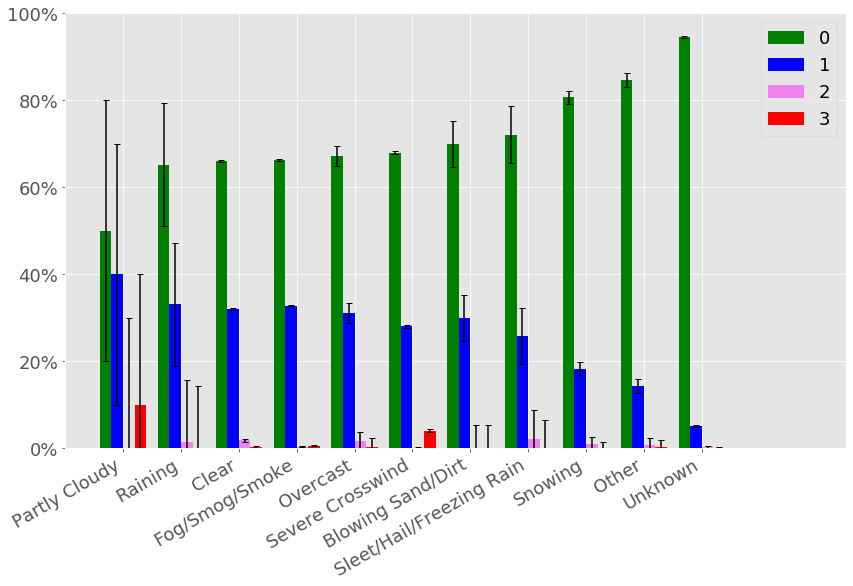

In [403]:
barWidth = 0.2

refPos = np.arange(len(df_weather_SC_prop.loc[:,0]))
barPos0 = [x - barWidth * 1.5 for x in refPos]
barPos1 = [x - barWidth / 2 for x in refPos]
barPos2 = [x + barWidth / 2 for x in refPos]
barPos3 = [x + barWidth * 1.5 for x in refPos]

fig = plt.figure(figsize = (14,8))
plt.rcParams.update({'font.size': 18})

plt.bar(barPos0, df_weather_SC_prop.loc[:,0] * 100, yerr = df_weather['sem'] * 100, capsize=3, color = 'green', width = barWidth, label = '0')
plt.bar(barPos1, df_weather_SC_prop.loc[:,1] * 100, yerr = df_weather['sem'] * 100, capsize=3, color = 'blue', width = barWidth, label = '1')
plt.bar(barPos2, df_weather_SC_prop.loc[:,2] * 100, yerr = df_weather['sem'] * 100, capsize=3, color = 'violet', width = barWidth, label = '2')
plt.bar(barPos3, df_weather_SC_prop.loc[:,3] * 100, yerr = df_weather['sem'] * 100, capsize=3, color = 'red', width = barWidth, label = '3')

axes = plt.gca()
axes.set_ylim([0, 100])
axes.set_xlim([-1, 12.5])
plt.xticks(refPos, df_weather_SC_prop.index.tolist(), rotation=30, ha='right')


axes.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.legend()


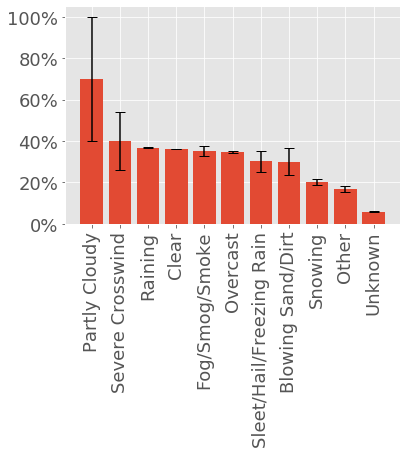

In [404]:
fig = plt.figure()

ax = fig.add_subplot(111)
plt.bar(list(df_weather.index), df_weather['mean'] * 100, yerr=df_weather['sem'] * 100, capsize=5)
plt.xticks(rotation='vertical')

ax.yaxis.set_major_formatter(mtick.PercentFormatter())

In [405]:
df_roadcond = df.groupby('ROADCOND')['SEVERITYCODE'].agg(['count', 'mean', 'std', 'sem'])
df_roadcond = df_roadcond.sort_values('mean', ascending = False)
df_roadcond

count      mean       std       sem
ROADCOND                                            
Other              118  0.364407  0.533738  0.049135
Wet              42250  0.361704  0.520053  0.002530
Dry             111481  0.360555  0.527453  0.001580
Oil                 54  0.351852  0.482032  0.065596
Standing Water      99  0.333333  0.534522  0.053722
Sand/Mud/Dirt       62  0.274194  0.449749  0.057118
Ice               1101  0.248865  0.466915  0.014072
Snow/Slush         873  0.180985  0.405530  0.013725
Unknown          12988  0.053280  0.234660  0.002059

In [406]:
df_hour = df.groupby('HOUR')['SEVERITYCODE'].agg(['count', 'mean', 'std', 'sem'])
#df_hour = df_hour.sort_values('mean', ascending = False)
df_hour

count      mean       std       sem
HOUR                                     
0      3990  0.269925  0.507722  0.008038
1      3550  0.303380  0.539314  0.009052
2      3729  0.289622  0.518749  0.008495
3      1738  0.256617  0.504185  0.012094
4      1276  0.271944  0.509237  0.014256
5      1727  0.329473  0.521568  0.012551
6      3331  0.363254  0.542063  0.009392
7      6748  0.363811  0.525875  0.006402
8      8788  0.337733  0.505304  0.005390
9      8258  0.324534  0.501210  0.005515
10     7669  0.310732  0.496536  0.005670
11     8414  0.318160  0.500479  0.005456
12    10680  0.311798  0.494535  0.004785
13    10487  0.326118  0.500874  0.004891
14    10917  0.345699  0.512516  0.004905
15    11871  0.352371  0.514575  0.004723
16    12474  0.362915  0.522414  0.004677
17    13350  0.381124  0.527244  0.004563
18    10068  0.382598  0.538221  0.005364
19     7465  0.342800  0.511887  0.005925
20     6434  0.313646  0.509060  0.006346
21     5792  0.334599  0.533387  0.007009
22     5628  0.310768  0.506132  0.006747
23     4765  0.280797  0.501947  0.007272

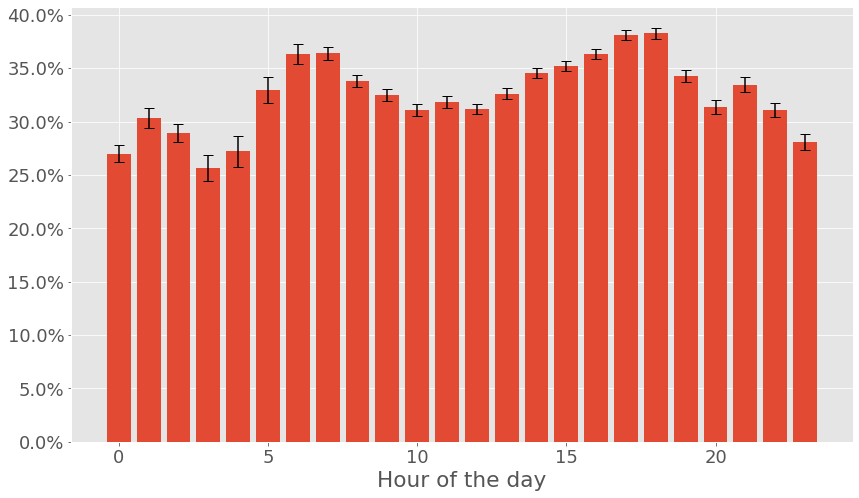

In [407]:
fig = plt.figure(figsize = (14,8))
plt.rcParams.update({'font.size': 18})

ax = fig.add_subplot(111)
plt.bar(list(df_hour.index), df_hour['mean'] * 100, yerr=df_hour['sem'] * 100, capsize=5)
plt.xlabel('Hour of the day')
#plt.xticks(rotation='vertical')

ax.yaxis.set_major_formatter(mtick.PercentFormatter())

In [408]:
#df_roadcond_SC_prop = df_roadcond_SC
#for i in df_roadcond_SC_prop.index.tolist():
#    df_roadcond_SC_prop.loc[i, :] = df_roadcond_SC.loc[i, :] / df_roadcond.loc[i, 'count']
    
#df_roadcond_SC_prop = df_roadcond_SC_prop.sort_values(0)

#df_roadcond_SC_prop

In [409]:
"""
barWidth = 0.2

refPos = np.arange(len(df_roadcond_SC_prop.loc[:,0]))
barPos0 = [x - barWidth * 1.5 for x in refPos]
barPos1 = [x - barWidth / 2 for x in refPos]
barPos2 = [x + barWidth / 2 for x in refPos]
barPos3 = [x + barWidth * 1.5 for x in refPos]

fig = plt.figure(figsize = (14,8))
plt.rcParams.update({'font.size': 18})

plt.bar(barPos0, df_roadcond_SC_prop.loc[:,0] * 100, yerr = df_roadcond['sem'] * 100, capsize=3, color = 'green', width = barWidth, label = '0')
plt.bar(barPos1, df_roadcond_SC_prop.loc[:,1] * 100, yerr = df_roadcond['sem'] * 100, capsize=3, color = 'blue', width = barWidth, label = '1')
plt.bar(barPos2, df_roadcond_SC_prop.loc[:,2] * 100, yerr = df_roadcond['sem'] * 100, capsize=3, color = 'violet', width = barWidth, label = '2')
plt.bar(barPos3, df_roadcond_SC_prop.loc[:,3] * 100, yerr = df_roadcond['sem'] * 100, capsize=3, color = 'red', width = barWidth, label = '3')

axes = plt.gca()
axes.set_ylim([0, 100])
axes.set_xlim([-1, 10.5])
plt.xticks(refPos, df_roadcond_SC_prop.index.tolist(), rotation=30, ha='right')


axes.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.legend()
"""

"\nbarWidth = 0.2\n\nrefPos = np.arange(len(df_roadcond_SC_prop.loc[:,0]))\nbarPos0 = [x - barWidth * 1.5 for x in refPos]\nbarPos1 = [x - barWidth / 2 for x in refPos]\nbarPos2 = [x + barWidth / 2 for x in refPos]\nbarPos3 = [x + barWidth * 1.5 for x in refPos]\n\nfig = plt.figure(figsize = (14,8))\nplt.rcParams.update({'font.size': 18})\n\nplt.bar(barPos0, df_roadcond_SC_prop.loc[:,0] * 100, yerr = df_roadcond['sem'] * 100, capsize=3, color = 'green', width = barWidth, label = '0')\nplt.bar(barPos1, df_roadcond_SC_prop.loc[:,1] * 100, yerr = df_roadcond['sem'] * 100, capsize=3, color = 'blue', width = barWidth, label = '1')\nplt.bar(barPos2, df_roadcond_SC_prop.loc[:,2] * 100, yerr = df_roadcond['sem'] * 100, capsize=3, color = 'violet', width = barWidth, label = '2')\nplt.bar(barPos3, df_roadcond_SC_prop.loc[:,3] * 100, yerr = df_roadcond['sem'] * 100, capsize=3, color = 'red', width = barWidth, label = '3')\n\naxes = plt.gca()\naxes.set_ylim([0, 100])\naxes.set_xlim([-1, 10.5])\npl

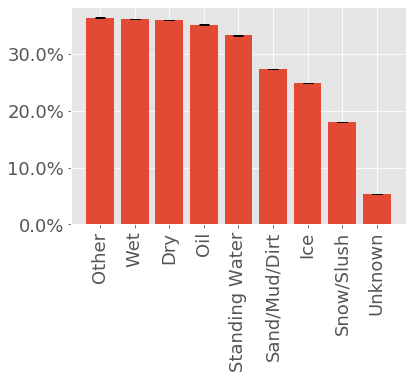

In [410]:
fig = plt.figure()

ax = fig.add_subplot(111)
plt.bar(list(df_roadcond.index), df_roadcond['mean'] * 100, yerr=df_roadcond['sem'], capsize=5)
plt.xticks(rotation='vertical')

ax.yaxis.set_major_formatter(mtick.PercentFormatter())

In [411]:
df_lightcond = df.groupby('LIGHTCOND')['SEVERITYCODE'].agg(['count', 'mean', 'std', 'sem']).sort_values('mean', ascending = False)
df_lightcond = df_lightcond.sort_values('mean', ascending = False)
df_lightcond

count      mean       std       sem
LIGHTCOND                                                     
Dawn                        2253  0.382601  0.543898  0.011459
Dusk                        5160  0.370736  0.533757  0.007431
Dark - Unknown Lighting       22  0.363636  0.492366  0.104973
Daylight                  103821  0.362798  0.519091  0.001611
Dark - Street Lights On    43430  0.343679  0.532839  0.002557
Dark - Street Lights Off    1061  0.329877  0.539517  0.016563
Other                        207  0.270531  0.486967  0.033847
Dark - No Street Lights     1378  0.249637  0.476099  0.012825
Unknown                    11524  0.047119  0.221514  0.002063

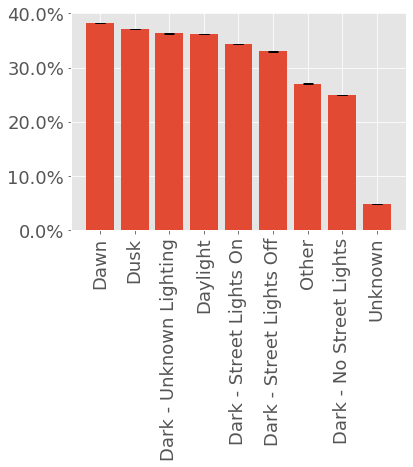

In [412]:
fig = plt.figure()

ax = fig.add_subplot(111)
plt.bar(list(df_lightcond.index), df_lightcond['mean'] * 100, yerr=df_lightcond['sem'], capsize=5)
plt.xticks(rotation='vertical')

ax.yaxis.set_major_formatter(mtick.PercentFormatter())

In [413]:
df['INCDATE'] = df.loc[:,'INCDATE'].str.split().str[0]
df.INCDATE = pd.to_datetime(df.INCDATE, format='%Y/%m/%d')

In [414]:
df['WEEKDAY'] = df['INCDATE'].dt.dayofweek
df['WEEKDAY'].replace(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], inplace = True)

df['WEEKDAY'] = pd.Categorical(df['WEEKDAY'], categories=
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'],
    ordered=True)

df_weekday = df.groupby('WEEKDAY')['SEVERITYCODE'].agg(['count', 'mean', 'std', 'sem'])
#df_weekday = df_weekday.sort_values('mean', ascending = False)
df_weekday

count      mean       std       sem
WEEKDAY                                       
Monday     22938  0.339306  0.514183  0.003395
Tuesday    24809  0.339836  0.513830  0.003262
Wednesday  25046  0.340414  0.515042  0.003254
Thursday   25430  0.347149  0.520278  0.003263
Friday     27961  0.333286  0.514076  0.003074
Saturday   23749  0.328477  0.512623  0.003326
Sunday     19216  0.315206  0.511629  0.003691

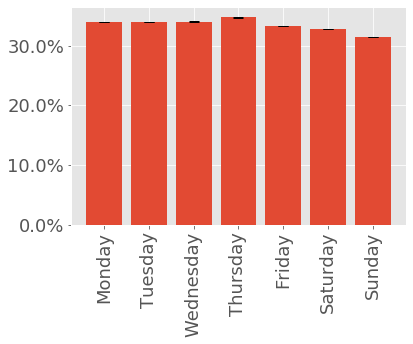

In [415]:
#plt.bar(list(df_weekday.index), df_weekday['mean'], yerr=df_weekday['sem'], capsize=5)
#plt.xticks(rotation='vertical')

fig = plt.figure()

ax = fig.add_subplot(111)
plt.bar(list(df_weekday.index), df_weekday['mean'] * 100, yerr=df_weekday['sem'], capsize=5)
plt.xticks(rotation='vertical')

ax.yaxis.set_major_formatter(mtick.PercentFormatter())

In [416]:
df.loc[:,'MONTH'] = df.loc[:,'INCDATE'].dt.month

month_list = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

df.loc[:,'MONTH'].replace(range(1,13), month_list, inplace = True)

df.loc[:,'MONTH'] = pd.Categorical(df['MONTH'], categories = month_list, ordered=True)

In [417]:

df_month = df.groupby('MONTH')['SEVERITYCODE'].agg(['count', 'mean', 'std', 'sem'])
#df_weekday = df_weekday.sort_values('mean', ascending = False)
df_month

count      mean       std       sem
MONTH                                         
January    14245  0.321025  0.507522  0.004252
February   12343  0.313538  0.500737  0.004507
March      14135  0.331022  0.513587  0.004320
April      13736  0.334886  0.512211  0.004370
May        14629  0.346914  0.516769  0.004273
June       14617  0.333653  0.510547  0.004223
July       14655  0.359058  0.528086  0.004362
August     14130  0.357396  0.529754  0.004457
September  13737  0.339230  0.519228  0.004430
October    15232  0.343619  0.516137  0.004182
November   14208  0.327914  0.512067  0.004296
December   13482  0.311972  0.504402  0.004344

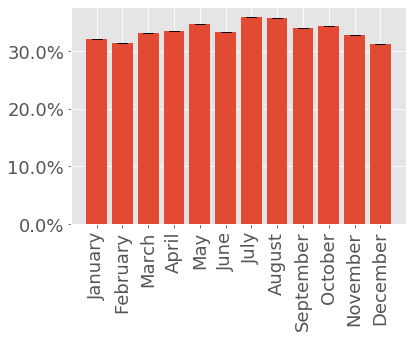

In [418]:
#plt.bar(list(df_month.index), df_month['mean'], yerr=df_month['sem'], capsize=5)
#plt.xticks(rotation='vertical')

fig = plt.figure()

ax = fig.add_subplot(111)
plt.bar(list(df_month.index), df_month['mean'] * 100, yerr=df_month['sem'], capsize=5)
plt.xticks(rotation='vertical')

ax.yaxis.set_major_formatter(mtick.PercentFormatter())

In [419]:
#!conda install -c conda-forge folium=0.11.0 --yes
import folium

seattle_map = folium.Map(location = [47.607568212024205,-122.32992013710938], zoom_start = 11)

seattle_map

In [420]:
df['YEAR'] = pd.DatetimeIndex(df.loc[:,'INCDATE']).year

df_year = df.groupby('YEAR')['SEVERITYCODE'].agg(['count', 'mean', 'std', 'sem'])
df_year

count      mean       std       sem
YEAR                                     
2004   8430  0.349822  0.530634  0.005779
2005  10822  0.325818  0.508423  0.004887
2006  10812  0.324639  0.520820  0.005009
2007  10310  0.304268  0.501865  0.004943
2008   9739  0.302392  0.497937  0.005046
2009   8483  0.322763  0.510474  0.005542
2010  10879  0.333487  0.514910  0.004937
2011  10445  0.307516  0.495891  0.004852
2012  10415  0.354873  0.522987  0.005125
2013  10092  0.350476  0.521975  0.005196
2014  11765  0.323247  0.506309  0.004668
2015  12908  0.310583  0.493380  0.004343
2016  11063  0.359848  0.519763  0.004942
2017  10630  0.353151  0.520740  0.005051
2018  10061  0.364576  0.523098  0.005215
2019   8941  0.376468  0.535831  0.005667
2020   3354  0.383423  0.546365  0.009434

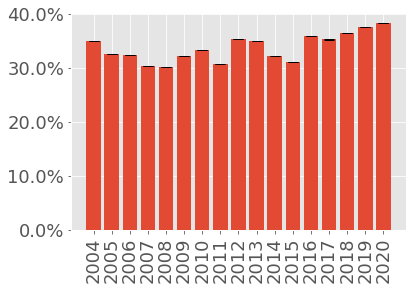

In [421]:
fig = plt.figure()

ax = fig.add_subplot(111)
plt.bar(list(map(str, list(df_year.index))), df_year['mean'] * 100, yerr=df_year['sem'], capsize=5)
plt.xticks(rotation='vertical')

ax.yaxis.set_major_formatter(mtick.PercentFormatter())

Text(0.5, 1.0, 'Yearly traffic accidents in Seattle')

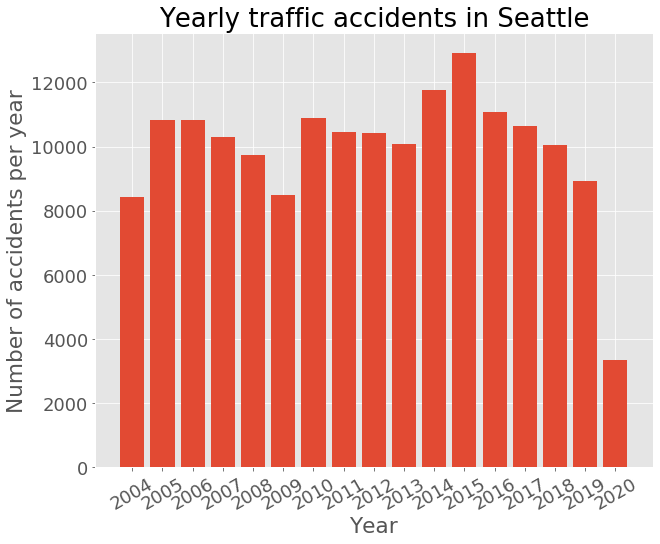

In [422]:
fig = plt.figure(figsize = (10,8))

ax = fig.add_subplot(111)
plt.bar(list(map(str, list(df_year.index))), df_year['count'], capsize=5)
plt.xticks(rotation = 30)
plt.ylabel('Number of accidents per year')
plt.xlabel('Year')
plt.title ('Yearly traffic accidents in Seattle')

In [423]:
min(df['INCDATE'])

Timestamp('2004-01-10 00:00:00')

In [424]:
df.INCDATE.head(15)

0    2013-03-14
1    2006-01-15
2    2019-09-09
6    2020-07-31
8    2006-04-11
9    2013-04-03
10   2013-03-30
11   2013-03-31
12   2006-06-13
13   2019-12-23
14   2007-04-17
15   2004-09-17
16   2019-12-20
17   2013-03-27
18   2020-05-03
Name: INCDATE, dtype: datetime64[ns]

In [425]:
df_withLocation = df[df.X.notnull()]

In [426]:
df_withLocation.shape

(164657, 24)

In [427]:
df_limit2020 = df_withLocation[df_withLocation.INCDATE > '2020']
df_limit2020.shape

(3311, 24)

In [433]:
seattle_map = folium.Map(location = [47.607568212024205,-122.32992013710938], zoom_start = 11)

seattle_map

accidents = folium.map.FeatureGroup()

for lat, lng, in zip(df_limit2020.Y, df_limit2020.X):
    accidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=500, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )
    
seattle_map.add_child(accidents)

In [446]:
seattle_map = folium.Map(location = [47.607568212024205,-122.32992013710938], zoom_start = 11)

seattle_map

accidents = folium.map.FeatureGroup()
accidents.add_child(
    folium.CircleMarker(
        [df_limit2020.Y[6], df_limit2020.X[6]],
        radius=2, # define how big you want the circle markers to be
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=1
    )
)
    
seattle_map.add_child(accidents)

In [447]:
[df_limit2020.Y[6], df_limit2020.X[6]]

[231901.4394, 1269242.946]